Those based in Toronto should be all too familiar with the TTC (Toronto Transit Commission), the city's public transit system. Most of us likely have a love-hate relationship with this essential but sometimes unreliable service. As someone who's lived in Toronto for more than a decade, the subway certainly *feels* slower, but I don't have evidence to back it up. So imagine my excitement when I discovered that the City of Toronto publishes data on subway delays through its Open Data Portal. As a regular commuter (I unfortunately have to commute 1.5h one way to get to/from work), I would be very interested in seeing whether there are any patterns I can take advantage of to shorten my own trips.

# TTC Subway Delay Data Prep

## Download Data

The data is available on https://open.toronto.ca/ in xlsx format by month (except for data covering 2014 - April 2017, which was contained in a single file). To download the data, I used the `pyopendatato` package I wrote. 

The raw data required some cleaning up, as shown below. Along with the data files, the package also comes with a README file and a table with the meaning of the delay codes.

In [1]:
import os
import re
import json
import calendar
import requests
import numpy as np
import pandas as pd
from pyopendatato.ckanTO import ckanTO as ckanTO

In [2]:
# Setup directories for organizing data
dirs = ['raw_data', 'processed_data', 'helper_data', 'weather_data'] 

for dir_i in dirs:
    if not os.path.exists(dir_i):
        os.makedirs(dir_i)

In [3]:
ct = ckanTO()

ct.search_packages(query = "subway")

,id,title,topics,excerpt,formats,num_resources,refresh_rate,last_refreshed,notes
0,996cfe8d-fb35-40ce-b569-698d51fc683b,TTC Subway Delay Data,Transportation,TTC Subway Delay Data,XLSX,35,Monthly,2020-02-03T19:05:49.504523,TTC Subway & SRT Train Service Delay Data\r\n\r\n
1,4eb6a6af-7199-4822-a89e-3e3ce5106d14,TTC Ridership - Subway-Scarborough RT Station ...,Transportation,This dataset lists typical subway station/SRT ...,XLSX,5,Annually,2017-12-31T00:00:00.000000,\r\n \r\nThis dataset lists typical subway ...
2,c01c6d71-de1f-493d-91ba-364ce64884ac,TTC Subway Shapefiles,None,This dataset contains separate shape files for...,SHP,1,As available,2018-04-30T00:00:00.000000,\r\nThis dataset contains separate shape files...


In [4]:
data_list = ct.get_package_metadata("996cfe8d-fb35-40ce-b569-698d51fc683b")['resources']

df = pd.DataFrame()
for data in data_list:
    if data["name"] not in ["ttc-subway-delay-codes", "ttc-subway-delay-readme"]:
        df = df.append(ct.get_resource(data["id"]))

df = df.drop_duplicates().reset_index(drop = True)

print(df.shape)
print(df.head())

(121783, 10)
        Date   Time        Day                Station   Code  Min Delay  \
0 2014-01-01  00:21  Wednesday  VICTORIA PARK STATION  MUPR1         55   
1 2014-01-01  02:06  Wednesday      HIGH PARK STATION   SUDP          3   
2 2014-01-01  02:40  Wednesday       SHEPPARD STATION  MUNCA          0   
3 2014-01-01  03:10  Wednesday      LANSDOWNE STATION   SUDP          3   
4 2014-01-01  03:20  Wednesday          BLOOR STATION  MUSAN          5   

   Min Gap Bound Line  Vehicle  
0       60     W   BD     5111  
1        7     W   BD     5001  
2        0   NaN   YU        0  
3        8     W   BD     5116  
4       10     S   YU     5386  


In [5]:
df.to_csv('raw_data/ttc_delay_raw_data.csv', index = False)

Here, each row represents a separate delay event. The date, time, day of week, station(s) affected, direction of train, subway line and train # are all recorded, in addition to the duration of delay (`Min Delay`) and the gap between the next train (`Min Gap`). 

## Map Delay Code to Delay Description

The `Code` column in the data represents the cause for the delay, but first we need to map it to its corresponding readable description. The legend provided requires some clean-up first to rearrange into a single table (the data is arranged in two panes by Subway versus SRT delay codes, but they can really be represented within the same table).

In [6]:
for data in data_list:
    if data["name"] == "ttc-subway-delay-codes":
        mapping = ct.get_resource(data["id"])

mapping.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,SUB RMENU CODE,CODE DESCRIPTION,NaN,NaN,SRT RMENU CODE,CODE DESCRIPTION
1,NaN,1.0,EUAC,Air Conditioning,NaN,1.0,ERAC,Air Conditioning
2,NaN,2.0,EUAL,Alternating Current,NaN,2.0,ERBO,Body
3,NaN,3.0,EUATC,ATC RC&S Equipment,NaN,3.0,ERCD,Consequential Delay (2nd Delay Same Fault)
4,NaN,4.0,EUBK,Brakes,NaN,4.0,ERCO,Couplers


In [7]:
mapping = mapping.drop(columns = ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 4', 'Unnamed: 5'], index = 0)
mapping.columns = ['code_sub', 'desc_sub', 'code_srt', 'desc_srt']

mapping = pd.concat([
    mapping[['code_sub', 'desc_sub']].rename(columns = {'code_sub': 'Code', 'desc_sub': 'Desc'}), 
    mapping[['code_srt', 'desc_srt']].rename(columns = {'code_srt': 'Code', 'desc_srt': 'Desc'})
])

mapping.Code = mapping.Code.str.strip()
mapping = mapping.dropna().reset_index(drop = True)

mapping.head()

,Code,Desc
0,EUAC,Air Conditioning
1,EUAL,Alternating Current
2,EUATC,ATC RC&S Equipment
3,EUBK,Brakes
4,EUBO,Body


In [8]:
df = df.merge(
    mapping, 
    on = 'Code', 
    how = 'left'
)

print(df.shape)
print(df.head())

(121783, 11)
        Date   Time        Day                Station   Code  Min Delay  \
0 2014-01-01  00:21  Wednesday  VICTORIA PARK STATION  MUPR1         55   
1 2014-01-01  02:06  Wednesday      HIGH PARK STATION   SUDP          3   
2 2014-01-01  02:40  Wednesday       SHEPPARD STATION  MUNCA          0   
3 2014-01-01  03:10  Wednesday      LANSDOWNE STATION   SUDP          3   
4 2014-01-01  03:20  Wednesday          BLOOR STATION  MUSAN          5   

   Min Gap Bound Line  Vehicle                                         Desc  
0       60     W   BD     5111  Priority One - Train in Contact With Person  
1        7     W   BD     5001                            Disorderly Patron  
2        0   NaN   YU        0                                          NaN  
3        8     W   BD     5116                            Disorderly Patron  
4       10     S   YU     5386                           Unsanitary Vehicle  


## Data Cleanup (Missingness, Inconsistent Values)

Next, I checked the level of data missingness. At a minimum, I'm interested in the station/line, reason for delay and length of delay. Ideally, the direction would also be useful to know.

In [9]:
df.isnull().sum()

Date             0
Time             0
Day              0
Station          0
Code             1
Min Delay        0
Min Gap          0
Bound        26554
Line           469
Vehicle          0
Desc          2501
dtype: int64

### Direction

Direction is missing roughly equally frequent between the four subway lines (they have the most number of records), so the missingness issue appears to be at random. Since there are too many values to impute, I won't be able to use this field in my analysis.

In [10]:
df.groupby('Line').apply(
    lambda x: pd.Series({
        'pct_missing_bound': x['Bound'].isnull().mean(),
        'n_obs': x.shape[0]})
).sort_values(by = 'n_obs', ascending = False)[:10]

,pct_missing_bound,n_obs
Line,,
BD,0.199883,56578.0
YU,0.214641,55022.0
SRT,0.227033,4365.0
SHP,0.182208,3968.0
YU/BD,0.997485,1193.0
B/D,0.241935,62.0
YU / BD,1.000000,25.0
YU/ BD,1.000000,14.0
YUS,0.857143,7.0


### Delay Reason Codes

There is 1 observation with missing delay code, as shown below. Since it is just a single observation and there is no other information to use to fill that in, I have chosen to remove the entry.

In [11]:
df[df.Code.isnull()]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc
72480,2017-07-07,06:09,Friday,COXWELL STATION,NaN,0,0,E,BD,5124,NaN


In [12]:
df = df[df.Code.notnull()]

print(df.shape)

(121782, 11)


### Delay Reason Descriptions

Some delay codes do not have a corresponding text description. It's not clear from the code values themselves what they mean. Could they be old codes or misspellings? There aren't many entries with invalid codes, so I should still be able to carry out my planned analysis on the causes for delays.

In [13]:
df[df.Desc.isnull()].Code.value_counts()[:10]

MUNCA    2297
TRNCA      86
PUEO       42
TUNCA      22
PUEWZ      13
MUPF        8
SFDP        4
XXXXX       4
MFO         4
MTUI        3
Name: Code, dtype: int64

Fill missing values in `Line`, `Bound`, `Desc` with an empty string value.

In [14]:
df = df.fillna('')

### Line

The TTC has 4 subway lines - YU (Yonge-University), BD (Bloor-Danforth), SHP (Sheppard) and SRT (Scarborough Rapid Transit), but there are a lot more values for the `Line` column in the raw data, including variations of the above lines and some that appear to be bus routes (?).

In [15]:
df.Line.value_counts()[:30]

BD                        56577
YU                        55022
SRT                        4365
SHP                        3968
YU/BD                      1193
                            469
B/D                          62
YU / BD                      25
YU/ BD                       14
YUS                           7
BD/YU                         6
BD LINE                       6
BD/YUS                        5
YU - BD                       5
999                           5
YU-BD                         3
11 BAYVIEW                    2
16 MCCOWAN                    2
YU LINE                       2
510 SPADINA                   2
60 STEELES WEST               1
95 YORK MILLS                 1
BLOOR DANFORTH                1
SHEPPARD                      1
985 SHEPPARD EAST EXPR        1
22 COXWELL                    1
YONGE UNIVERSITY SERVI        1
73 ROYAL YORK                 1
25 DON MILLS                  1
29 DUFFERIN                   1
Name: Line, dtype: int64

To handle the missing line information, first, the values that seemingly refer to a bus route are removed, since I'm only interested in subway delays for this exercise. 

Next, the line values are mapped to a consistent naming convention (e.g. all references to the Yonge-University line should be labeled "YU"). If the line information is missing, I can try to fill it in if the station is provided. Sometimes it is not clear which line experienced the delay, since there are 5 stations where transfers between lines are possible. In these cases, I have elected to assign a naming convention that combines both lines. For example, if the delay occurred at the intersection between Yonge-University and Bloor-Danforth lines, it would be assigned to "YU_BD".

In [16]:
df['line_cleaned'] = df.Line

df = df[~df.line_cleaned.str.contains('^[0-9]')]
print(df.shape)

(121741, 12)


In [17]:
line_spelling_table = pd.read_csv(
    'helper_data/line_spellings.csv', 
    escapechar = '\\'
)
print(line_spelling_table.head())

line_spelling_mapping = dict(
    zip(line_spelling_table.line_raw, line_spelling_table.line_cleaned)
)

               line_raw line_cleaned
0               BD LINE           BD
1        BLOOR DANFORTH           BD
2   BLOOR DANFORTH LINE           BD
3                   B/D           BD
4  BLOOR DANFORTH LINES           BD


In [18]:
df.line_cleaned = list(map(
    lambda x: line_spelling_mapping.get(x, x), 
    df.line_cleaned
))

df.line_cleaned.unique()

array(['BD', 'YU', 'SHP', 'SRT', '', 'YU_BD', 'YU_SHP'], dtype=object)

In [19]:
line_station_table = pd.read_csv('helper_data/line_station_mapping.csv')
print(line_station_table.head())

line_station_mapping = dict(
    zip(line_station_table.Station, line_station_table.Line)
)

                Station Line
0      BATHURST STATION   BD
1           BAY STATION   BD
2     BROADVIEW STATION   BD
3  CASTLE FRANK STATION   BD
4       CHESTER STATION   BD


In [20]:
df.line_cleaned = list(map(
    lambda x, y: line_station_mapping.get(y, x) if x == '' else x, 
    df.line_cleaned, 
    df.Station
))

After above cleanup, the few remaining observations with missing line info do not appear related to subway train delays, as shown below, so they can be removed from analysis. 

In [21]:
df[df.line_cleaned == ''].Station.value_counts()[:30]

GREENWOOD CARHOUSE        18
WILSON CARHOUSE           15
GREENWOOD YARD            13
DANFORTH DIVISION         10
GUNN BUILDING              5
GREENWOOD SHOP             5
DAVISVILLE YARD            5
WILSON HOSTLER             4
TRANSIT CONTROL CENTRE     4
MCBRIEN BUILDING           4
WILSON YARD                4
DUNCAN SHOP                4
HARVEY SHOP                3
DAVISVILLE CARHOUSE        3
INGLIS BUILDING            2
GREENWOOD SHOPS            2
UNION TO MAIN STREET       1
GREENWOOD WYE              1
TRANSIT CONTROL            1
DAVENPORT BUILDING         1
RONCEVALLES DIVISION       1
GLENAYR SUBSTATION         1
DAVISVILLE YARD - TUNN     1
40 CARL HALL ROAD UNIT     1
SCARBOROUGH CTR STATIO     1
EGLINTON BUS TERMINAL      1
ST GEORGE SIGNALS OFFI     1
SUBWAY OPS BUILDING        1
PLANT OPS BLDG             1
DUNCAN SHOPS               1
Name: Station, dtype: int64

In [22]:
df = df[df.line_cleaned != ''].reset_index(drop = True)

print(df.shape)
print(df.head())

(121617, 12)
        Date   Time        Day                Station   Code  Min Delay  \
0 2014-01-01  00:21  Wednesday  VICTORIA PARK STATION  MUPR1         55   
1 2014-01-01  02:06  Wednesday      HIGH PARK STATION   SUDP          3   
2 2014-01-01  02:40  Wednesday       SHEPPARD STATION  MUNCA          0   
3 2014-01-01  03:10  Wednesday      LANSDOWNE STATION   SUDP          3   
4 2014-01-01  03:20  Wednesday          BLOOR STATION  MUSAN          5   

   Min Gap Bound Line  Vehicle                                         Desc  \
0       60     W   BD     5111  Priority One - Train in Contact With Person   
1        7     W   BD     5001                            Disorderly Patron   
2        0         YU        0                                                
3        8     W   BD     5116                            Disorderly Patron   
4       10     S   YU     5386                           Unsanitary Vehicle   

  line_cleaned  
0           BD  
1           BD  
2         

### Station

The station name field contains several types of inconsistencies that need to be cleaned up: 
- inconsistent spelling of station names
- missing station info
- entries that refer to a stretch of consecutive stations ("A to B")

To simplify things, we can first remove punctuation marks from all station names. 

In [23]:
df['station_cleaned'] = [re.sub('\.|\'', '', re.sub(' \(.*$', '', x)) for x in df.Station]

Next, I created a mapping table to try to fix the station names. Unfortunately, I don't think this part of the process can be automated much since there are many kinds of inconsistencies.

In [24]:
station_fixed_mapping = pd.read_csv('helper_data/station_spellings.csv')
station_fixed_mapping.head()

,station_cleaned,station_fixed
0,KIPLING STATION,KIPLING STATION
1,KENNEDY BD STATION,KENNEDY BD STATION
2,YONGE UNIVERSITY LINE,YU
3,FINCH STATION,FINCH STATION
4,SHEPPARD WEST STATION,SHEPPARD WEST STATION


In [25]:
df = df.merge(
    station_fixed_mapping, 
    on = 'station_cleaned', 
    how = 'left'
)

print(df.shape)

(121617, 14)


As shown below, some entries appear to refer to places that are not subway stops (e.g. 'GREENWOOD CARHOUSE', 'MCBRIEN BUILDING'). I will remove those from the data since they are likely not subway train delays.

In [26]:
df[df.station_fixed.isnull()].station_cleaned.value_counts()[:30]

GREENWOOD YARD            304
TORONTO TRANSIT COMMIS    276
WILSON HOSTLER            219
WILSON YARD               218
GREENWOOD WYE             127
DAVISVILLE YARD           103
DAVISVILLE HOSTLER         76
WILSON CARHOUSE            63
MCCOWAN YARD               62
GREENWOOD PORTAL           55
GREENWOOD CARHOUSE         42
KEELE YARD                 22
DANFORTH DIVISION          16
TRANSIT CONTROL CENTRE     14
DAVISVILLE CARHOUSE        13
SHEPPARD WEST MIGRATIO     10
GREENWOOD SHOP             10
DAVISVILLE BUILD UP         8
BAY LOWER                   6
SHEPPARD WEST PORTAL        6
MCBRIEN BUILDING            6
GREENWOOD SHOPS             6
GUNN BUILDING               4
WILSON HOSLTER              4
MCCOWAN CARHOUSE            4
WILSON DIVISION             4
CHESTER TO BROADVIEW        3
OSGOODE POCKET              3
N/O DAVISVILLE TO N/O       3
LYTTON EMERGENCY EXIT       3
Name: station_cleaned, dtype: int64

In [27]:
df = (df[~df.station_fixed.isnull()].reset_index(drop = True)
                                    .drop(columns = ['station_cleaned'])
                                    .rename(columns = {'station_fixed': 'station_cleaned'}))

print(df.shape)
print(df.head())

(119665, 13)
        Date   Time        Day                Station   Code  Min Delay  \
0 2014-01-01  00:21  Wednesday  VICTORIA PARK STATION  MUPR1         55   
1 2014-01-01  02:06  Wednesday      HIGH PARK STATION   SUDP          3   
2 2014-01-01  02:40  Wednesday       SHEPPARD STATION  MUNCA          0   
3 2014-01-01  03:10  Wednesday      LANSDOWNE STATION   SUDP          3   
4 2014-01-01  03:20  Wednesday          BLOOR STATION  MUSAN          5   

   Min Gap Bound Line  Vehicle                                         Desc  \
0       60     W   BD     5111  Priority One - Train in Contact With Person   
1        7     W   BD     5001                            Disorderly Patron   
2        0         YU        0                                                
3        8     W   BD     5116                            Disorderly Patron   
4       10     S   YU     5386                           Unsanitary Vehicle   

  line_cleaned        station_cleaned  
0           BD  VICTO

### Ambiguous Station-Line Info for Intersection Stations

Some stations could belong to two intersecting subway lines (e.g. Bloor-Yonge, St. George) and the raw data does not always distinguish them (e.g. Kennedy Station versus Kennedy BD Station), thereby creating confusions. Here, I tried as best as I could to distinguish between the station-lines by making the station names slightly different.

In [28]:
intersection_mapping = pd.read_csv('helper_data/intersections.csv')
intersection_mapping.head()

,line_cleaned,station_cleaned,line_fixed,station_fixed
0,BD,BLOOR STATION,BD,YONGE BD STATION
1,BD,"BROADVIEW STATION, YONGE BD STATION",BD,NaN
2,BD,KENNEDY BD STATION,BD,KENNEDY BD STATION
3,BD,"KENNEDY BD STATION, KIPLING STATION",BD,"KENNEDY BD STATION, KIPLING STATION"
4,BD,KENNEDY STATION,BD,KENNEDY BD STATION


In [29]:
df = df.merge(
    intersection_mapping, 
    on = ['line_cleaned', 'station_cleaned'], 
    how = 'left'
)

df.line_cleaned = list(map(
    lambda x, y: y if not pd.isna(y) else x, 
    df.line_cleaned, 
    df.line_fixed
))

df.station_cleaned = list(map(
    lambda x, y: y if not pd.isna(y) else x, 
    df.station_cleaned, 
    df.station_fixed
))

df = df.drop(columns = ['line_fixed', 'station_fixed'])

print(df.shape)
print(df.head())

(119665, 13)
        Date   Time        Day                Station   Code  Min Delay  \
0 2014-01-01  00:21  Wednesday  VICTORIA PARK STATION  MUPR1         55   
1 2014-01-01  02:06  Wednesday      HIGH PARK STATION   SUDP          3   
2 2014-01-01  02:40  Wednesday       SHEPPARD STATION  MUNCA          0   
3 2014-01-01  03:10  Wednesday      LANSDOWNE STATION   SUDP          3   
4 2014-01-01  03:20  Wednesday          BLOOR STATION  MUSAN          5   

   Min Gap Bound Line  Vehicle                                         Desc  \
0       60     W   BD     5111  Priority One - Train in Contact With Person   
1        7     W   BD     5001                            Disorderly Patron   
2        0         YU        0                                                
3        8     W   BD     5116                            Disorderly Patron   
4       10     S   YU     5386                           Unsanitary Vehicle   

  line_cleaned        station_cleaned  
0           BD  VICTO

### Inconsistencies Between Station and Line

Next, I checked for mismatches between the line and the station provided (i.e. the station actually belongs to a different subway line) by comparing whether the line corresponding to the provided station is the same as in the raw data.

In [30]:
df = df.merge(
    line_station_table[['Station', 'Line']].drop_duplicates().rename(
        columns = {'Station': 'station_cleaned', 'Line': 'line_mapped'}
    ), 
    on = 'station_cleaned',
    how = 'left'
)

print(df.shape)

(119665, 14)


In [31]:
df[(df.line_mapped != df.line_cleaned) & 
   (df.Line != '')][['station_cleaned', 'line_cleaned', 'line_mapped']].drop_duplicates()

,station_cleaned,line_cleaned,line_mapped
78,YU,YU,NaN
144,BD,BD,NaN
238,YU,BD,NaN
463,"MCCOWAN STATION, KENNEDY SRT STATION",SRT,NaN
1485,WARDEN STATION,SHP,BD
1500,GLENCAIRN STATION,BD,YU
2008,BESSARION STATION,YU,SHP
2394,BAY STATION,YU,BD
2723,BD,YU_BD,NaN
3342,YU,SHP,NaN


Out of the above, delay events affecting multiple stations all have the correct line information:

In [32]:
df[(df.line_mapped != df.line_cleaned) & 
   (df.Line != '') & 
   (df.station_cleaned.str.contains(','))][['station_cleaned', 'line_cleaned', 'line_mapped']].drop_duplicates()

,station_cleaned,line_cleaned,line_mapped
463,"MCCOWAN STATION, KENNEDY SRT STATION",SRT,NaN
9993,"KENNEDY BD STATION, KIPLING STATION",BD,NaN
11894,"FINCH STATION, DOWNSVIEW PARK STATION",YU,NaN
13043,"EGLINTON STATION, LAWRENCE STATION",YU,NaN
29998,"PAPE STATION, ST GEORGE BD STATION",BD,NaN
39101,"FINCH STATION, LAWRENCE STATION",YU,NaN
69225,"UNION STATION, KING STATION",YU,NaN
69965,"ST GEORGE BD STATION, BROADVIEW STATION",BD,NaN
73388,"KIPLING STATION, ISLINGTON STATION",BD,NaN
73708,"KIPLING STATION, ROYAL YORK STATION",BD,NaN


When the station name is the subway line name, I will assume that the whole line was affected.

In [33]:
df[(df.line_mapped != df.line_cleaned) & 
   (df.station_cleaned.isin(['YU', 'BD', 'SHP', 
                             'SRT', 'YU_BD_SHP', 
                             'YU_BD', 'ALL']))][['station_cleaned', 'line_cleaned', 'line_mapped']].drop_duplicates()

,station_cleaned,line_cleaned,line_mapped
78,YU,YU,NaN
144,BD,BD,NaN
238,YU,BD,NaN
2723,BD,YU_BD,NaN
3342,YU,SHP,NaN
6816,YU,YU_BD,NaN
8553,SHP,SHP,NaN
11446,BD,YU,NaN
13195,YU_BD_SHP,YU,NaN
18881,ALL,YU,NaN


For the remaining entries, we do not know whether the station or the line was entered incorrectly, so I discarded those.

In [34]:
df[(df.line_mapped != df.line_cleaned) & 
   (~df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'YU_BD_SHP', 'YU_BD', 'ALL'])) & 
   (~df.station_cleaned.str.contains(',')) & 
   (df.line_cleaned != df.station_cleaned)][['station_cleaned', 'line_cleaned', 'line_mapped']].drop_duplicates()

,station_cleaned,line_cleaned,line_mapped
1485,WARDEN STATION,SHP,BD
1500,GLENCAIRN STATION,BD,YU
2008,BESSARION STATION,YU,SHP
2394,BAY STATION,YU,BD
3343,ST CLAIR STATION,SHP,YU
4455,DON MILLS STATION,YU,SHP
5730,LAWRENCE STATION,SRT,YU
11087,DAVISVILLE STATION,BD,YU
12859,KING STATION,BD,YU
12964,GREENWOOD STATION,YU,BD


In [35]:
mask = ~((df.line_mapped != df.line_cleaned) & 
         (~df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'YU_BD_SHP', 'YU_BD', 'ALL'])) &
         (~df.station_cleaned.str.contains(',')) & 
         (df.line_cleaned != df.station_cleaned))

print(sum(~mask))

90


In [36]:
df = df[mask].reset_index(drop = True)

assert df.shape[0] == (len(mask) - sum(~mask))
print(df.shape)

(119575, 14)


### Delay Duration

In [37]:
df['Min Delay'].hist(bins = 25)

Of all the really long delays, there is one entry for 999 minutes, which sounds suspiciously like a filler value. Since there is just one entry (the other long duration event entries look reasonable), I did not remove anything based on the `Min Delay` field except for the one at 999 minutes.

In [38]:
df[df['Min Delay'] > 200]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned,station_cleaned,line_mapped
632,2014-01-11,20:51,Saturday,MCCOWAN STATION TO KEN,MRWEA,292,298,S,SRT,3014,Weather Reports / Related Delays,SRT,"MCCOWAN STATION, KENNEDY SRT STATION",NaN
2019,2014-02-05,12:35,Wednesday,MCCOWAN STATION,MRWEA,788,0,S,SRT,3012,Weather Reports / Related Delays,SRT,MCCOWAN STATION,SRT
9021,2014-06-10,14:58,Tuesday,FINCH STATION,PUSI,202,205,S,YU,5781,Signals or Related Components Failure,YU,FINCH STATION,YU
11919,2014-08-05,05:11,Tuesday,ST CLAIR WEST STATION,PUMO,340,343,N,YU,5631,Station Other,YU,ST CLAIR WEST STATION,YU
15004,2014-09-30,07:55,Tuesday,DUNDAS WEST STATION,PUTS,424,426,W,BD,5094,Structure Related Problem,BD,DUNDAS WEST STATION,BD
15959,2014-10-16,19:58,Thursday,LAWRENCE STATION,MUWEA,247,250,S,YU,5856,Weather Reports / Related Delays,YU,LAWRENCE STATION,YU
22088,2015-02-07,15:30,Saturday,KENNEDY SRT STATION,ERHV,555,600,N,SRT,3015,High Voltage,SRT,KENNEDY SRT STATION,SRT
22647,2015-02-17,06:56,Tuesday,MCCOWAN STATION TO KEN,ERHV,999,999,N,SRT,3007,High Voltage,SRT,"MCCOWAN STATION, KENNEDY SRT STATION",NaN
23662,2015-03-04,05:40,Wednesday,KENNEDY BD STATION,MUFM,389,393,W,BD,5105,Force Majeure,BD,KENNEDY BD STATION,BD
24886,2015-03-24,05:59,Tuesday,COLLEGE STATION,MUFM,452,0,N,YU,5781,Force Majeure,YU,COLLEGE STATION,YU


In [39]:
df = df[df['Min Delay'] < 999]

print(df.shape)

(119574, 14)


There are a lot of entries for delays lasting 0 minutes...maybe they were just very short (under a minute)? A lot of my planned analysis will revolve around the duration of delays, so it does not make sense to have 0-minute durations. I replaced the 0's with 0.5, assuming the delays were very short-lived.

In [40]:
(df['Min Delay'] == 0).mean()

0.6987555823172261

In [41]:
df['Min Delay'] = df['Min Delay'].replace(0, 0.5)

assert (df['Min Delay'] == 0).sum() == 0

### Delays Affecting Multiple Stations

When a delay affects multiple stations/lines, the station name field will contain both from and to stations. Since I plan to analyze delay patterns by individual stations, I will split those delay entries into multiple rows, one for each station, with the delay duration split equally between the stations, and have a separate row for each station affected. This means that I also need to have indicator variables to avoid double counting the number of delays when computing counts over stations.

In [42]:
with open('helper_data/stations_ordered.json') as json_file:
    stations_ordered = json.load(json_file)
    
num_stations = {
    'YU': 38, 
    'BD': 31, 
    'YU_BD': 69,
    'SRT': 6,
    'SHP': 5,
    'YU_BD_SHP': 74,
    'ALL': 80  
}

all_stations = sum(stations_ordered.values(), [])

In [43]:
df_mult_station = df[(df.station_cleaned.str.contains(',')) | 
                     (df.station_cleaned.str.contains('_')) |
                     (df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))].copy()

new_df = pd.DataFrame()

for index, row in df_mult_station.iterrows():
    
    st = row['station_cleaned']
    
    if st in ['YU', 'BD', 'SRT', 'SHP']:
        df_i = pd.concat([row.to_frame(0).T] * num_stations[st])
        df_i.station_cleaned = stations_ordered[st]
    
    elif '_' in st:
        df_i = pd.concat([row.to_frame(0).T] * num_stations[st])       
        df_i.station_cleaned = sum([stations_ordered[st_i] for st_i in st.split('_')], [])
        
    elif st == 'ALL':
        df_i = pd.concat([row.to_frame(0).T] * num_stations[st])       
        df_i.station_cleaned = sum([stations_ordered[k] for k in stations_ordered], [])
    
    else:
        
        fr_stn, to_stn = st.split(', ')
        fr_idx_temp = stations_ordered[row['line_cleaned']].index(fr_stn)
        to_idx_temp = stations_ordered[row['line_cleaned']].index(to_stn)
        fr_idx, to_idx = min(fr_idx_temp, to_idx_temp), max(fr_idx_temp, to_idx_temp)
        
        stations = stations_ordered[row['line_cleaned']][fr_idx:(to_idx + 1)]
        df_i = pd.concat([row.to_frame(0).T] * len(stations))
        df_i.station_cleaned = stations
    
    df_i['Min Delay'] /= df_i.shape[0]
    df_i['indicator_ns'] = [1] + [0] * (df_i.shape[0] - 1)
    df_i['indicator_station'] = [1] * df_i.shape[0]
    
    new_df = new_df.append(df_i)

print(new_df.shape)

(321990, 16)


After the above, there are now two entries with ambiguous station names, both occured at Spadina Station, which is a point of intersection between the YU and BD subway lines. Since we do not know which line the delay occured, I assumed that it is at both stations affected, and allocated the delay duration equally between then.

In [44]:
df[(~df.station_cleaned.isin(all_stations)) &
   (~df.station_cleaned.str.contains(',')) & 
   (~df.station_cleaned.str.contains('_')) & 
   (~df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))]

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Desc,line_cleaned,station_cleaned,line_mapped
78756,2017-12-02,22:39,Saturday,SPADINA STATION,MUIS,0.5,0,E,,0,Injured or ill Customer (In Station) - Transpo...,YU_BD,SPADINA STATION,YU_BD
83162,2018-02-16,16:02,Friday,SPADINA STATION,SUAE,0.5,0,,,0,Assault / Employee Involved,YU_BD,SPADINA STATION,YU_BD


In [45]:
df_mult_line = df[(~df.station_cleaned.isin(all_stations)) &
                  (~df.station_cleaned.str.contains(',')) & 
                  (~df.station_cleaned.str.contains('_')) & 
                  (~df.station_cleaned.isin(['YU', 'BD', 'SHP', 'SRT', 'ALL']))].copy()

for index, row in df_mult_line.iterrows():
    
    stations = ['SPADINA YU STATION', 'SPADINA BD STATION']
    df_i = pd.concat([row.to_frame(0).T] * len(stations))
    df_i.station_cleaned = stations
    
    df_i['Min Delay'] /= df_i.shape[0]
    df_i['indicator_ns'] = [1] + [0] * (df_i.shape[0] - 1)
    df_i['indicator_station'] = [1] * df_i.shape[0]
    
    new_df = new_df.append(df_i)

print(new_df.shape)

(321994, 16)


In [46]:
df_no_mult = df[df.station_cleaned.isin(all_stations)].copy()
df_no_mult['indicator_ns'] = 1
df_no_mult['indicator_station'] = 1

new_df = new_df.append(df_no_mult).reset_index(drop = True)

print(new_df.shape)
print(new_df.head())

(433252, 16)
                  Date   Time       Day                Station  Code  \
0  2014-01-02 00:00:00  11:30  Thursday  YONGE UNIVERSITY LINE  MUGD   
1  2014-01-02 00:00:00  11:30  Thursday  YONGE UNIVERSITY LINE  MUGD   
2  2014-01-02 00:00:00  11:30  Thursday  YONGE UNIVERSITY LINE  MUGD   
3  2014-01-02 00:00:00  11:30  Thursday  YONGE UNIVERSITY LINE  MUGD   
4  2014-01-02 00:00:00  11:30  Thursday  YONGE UNIVERSITY LINE  MUGD   

   Min Delay Min Gap Bound Line Vehicle                          Desc  \
0  0.0131579       0         YU       0  Miscellaneous General Delays   
1  0.0131579       0         YU       0  Miscellaneous General Delays   
2  0.0131579       0         YU       0  Miscellaneous General Delays   
3  0.0131579       0         YU       0  Miscellaneous General Delays   
4  0.0131579       0         YU       0  Miscellaneous General Delays   

  line_cleaned          station_cleaned line_mapped  indicator_ns  \
0           YU       VAUGHAN MC STATION       

In [47]:
# Check that I did not miss any entries
assert df_mult_line.shape[0] + df_mult_station.shape[0] + df[df.station_cleaned.isin(all_stations)].shape[0] == df.shape[0]
assert df.shape[0] == new_df.indicator_ns.sum()
assert round(df['Min Delay'].sum(), 2) == round(new_df['Min Delay'].sum(), 2)

### Date/Time

First, I checked to see whether the week day information is correct.

In [48]:
new_df['weekday'] = list(map(lambda x: calendar.day_name[x.weekday()], new_df.Date))

assert new_df[new_df.weekday != new_df.Day].shape[0] == 0

new_df = new_df.drop(columns = 'Day') # Just need to keep one of the two columns snce they are the same

Next, I extracted the year, month, day and hour as separate features, since I'd be interested in studying seasonality of delay patterns.

In [49]:
new_df['year'] = list(map(lambda x: x.year, new_df.Date))
new_df['month'] = list(map(lambda x: x.month, new_df.Date))
new_df['day'] = list(map(lambda x: x.month, new_df.Date))
new_df['hour'] = list(map(lambda x: int(x.split(':')[0]), new_df.Time))

The date range and daily delay counts both look reasonable (we should have data for 2014 - 2019). We have some days with few or many delays, but they form the thin tails of the distribution, with most days experiencing 50 - 70 delays.

In [50]:
new_df['Date'].agg(['min', 'max'])

min   2014-01-01
max   2019-12-31
Name: Date, dtype: datetime64[ns]

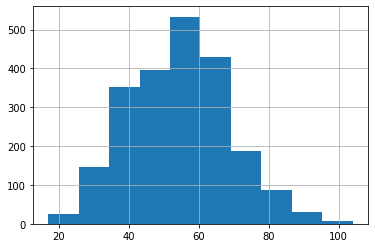

In [51]:
new_df.groupby('Date')['indicator_ns'].sum().hist()

February 5, 2014, the day with the highest number of delays, was the day of very heavy snowfall in Toronto (so bad that it led to many school bus cancellations), so it makes sense to expect a lot of delays on that day. May 22, 2016, the day with the lowest number of delays, was a Sunday. With less traffic and trains running less frequently, it is plausible that there are fewer delays.

In [52]:
new_df.groupby('Date')['indicator_ns'].sum().sort_values()

Date
2016-05-22     17
2017-02-25     19
2019-07-14     21
2017-04-30     21
2018-01-28     22
2017-09-16     22
2017-01-15     23
2016-11-13     23
2018-10-14     23
2014-01-12     24
2018-03-25     24
2017-02-18     24
2016-06-05     24
2014-04-06     24
2018-12-30     24
2016-05-15     24
2015-08-23     25
2014-10-26     25
2019-09-14     25
2016-02-28     25
2019-07-07     25
2017-01-22     25
2014-12-25     25
2019-07-13     25
2019-04-21     26
2017-03-26     26
2014-03-23     26
2017-10-08     26
2016-03-12     26
2017-07-09     26
             ... 
2016-08-04     87
2018-04-30     88
2019-05-10     88
2015-09-08     89
2016-12-12     89
2014-03-10     90
2019-01-23     90
2015-03-09     90
2014-02-14     90
2019-01-31     90
2016-12-01     91
2019-01-30     91
2015-02-06     91
2016-11-21     91
2018-07-09     92
2015-02-25     92
2016-08-11     92
2019-05-17     92
2016-11-22     93
2014-01-27     93
2015-02-24     94
2016-09-07     95
2014-02-13     95
2018-06-01     96
2014-

It seems a lot of the delay times are rounded (i.e. turn of the hour, half-hour mark), but this should hopefully not affect the analysis much since I don't plan to segment by anything more granular than hourly. 

## Save Results

In [53]:
new_df.columns = [re.sub(' ', '_', x.lower()) for x in new_df.columns]
        
new_df[['date', 'time', 
        'year', 'month', 'day', 
        'weekday', 'hour',
        'line_cleaned', 'station_cleaned', 
        'code', 'desc', 'min_delay', 
        'indicator_ns', 'indicator_station']].to_csv('processed_data/ttc_subway_delay_data.csv', index = False)

# Get Historical Weather Data

One question I wanted to explore was if weather (i.e. heavy rain or snow) affects commute time. For this, I downloaded historical weather data from Environment Canada for 2014 - 2019. The daily data in csv format is available for download by year. 

In [54]:
years = [2014, 2015, 2016, 2017, 2018, 2019]

for year in years:
    
    url = f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID=51459&Year={year}&timeframe=2&submit=Download+Data"
    fname = f"weather_data/daily_weather_{year}.csv"
    
    with requests.get(url, stream = True) as r:
        with open(fname, 'wb') as f:
            f.write(r.content)

In [55]:
weather = pd.DataFrame()
for year in years:
    
    fname = f"weather_data/daily_weather_{year}.csv"
    weather_i = pd.read_csv(fname)
    weather = weather.append(weather_i)
    os.remove(fname)

weather = weather.rename(
    columns = {
        'Date/Time': 'date', 
        'Total Rain (mm)': 'rain_mm', 
        'Total Snow (cm)': 'snow_cm'
    }).reset_index(drop = True)

print(weather.shape)
print(weather.head())

(2191, 31)
   Longitude (x)  Latitude (y)    Station Name  Climate ID        date  Year  \
0         -79.63         43.68  TORONTO INTL A     6158731  2014-01-01  2014   
1         -79.63         43.68  TORONTO INTL A     6158731  2014-01-02  2014   
2         -79.63         43.68  TORONTO INTL A     6158731  2014-01-03  2014   
3         -79.63         43.68  TORONTO INTL A     6158731  2014-01-04  2014   
4         -79.63         43.68  TORONTO INTL A     6158731  2014-01-05  2014   

   Month  Day  Data Quality  Max Temp (°C)  ... snow_cm  Total Snow Flag  \
0      1    1           NaN          -10.0  ...     0.0              NaN   
1      1    2           NaN          -15.2  ...     1.0              NaN   
2      1    3           NaN           -9.2  ...     0.0              NaN   
3      1    4           NaN           -0.4  ...     0.4              NaN   
4      1    5           NaN           -0.1  ...    11.6              NaN   

  Total Precip (mm)  Total Precip Flag Snow on Grnd

In [56]:
weather.to_csv('weather_data/daily_weather.csv', index = False)